<a href="https://colab.research.google.com/github/Aryan2005-tech/Hate_lens/blob/main/Hate_speech_(3)_(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vaderSentiment
!pip install transformers
!pip install spacy
!pip install tensorflow_hub
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
%%writefile feature_extractor_hatespeechnet_merged.py
# placeholder file so the import works
# We will NOT run the full extractor again.
pass


Writing feature_extractor_hatespeechnet_merged.py


In [ ]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from typing import List, Dict, Any, Optional
from datasets import load_dataset
import unicodedata
import warnings

In [ ]:
!pip install "datasets<2.15.0"

In [ ]:
from datasets import load_dataset

print("Loading HateXplain dataset...")

# This command will work correctly with version 2.14.5
hatexplain_dataset = load_dataset("Hate-speech-CNERG/hatexplain",split="train")

print("✅ HateXplain loaded successfully!")

Loading HateXplain dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/15383 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

✅ HateXplain loaded successfully!


In [ ]:
import pandas as pd
hatexplain_df = hatexplain_dataset.to_pandas()
print(f"✅ Loaded {len(hatexplain_df)} samples from HateXplain.")

✅ Loaded 15383 samples from HateXplain.


In [ ]:
hatexplain_df.head(10)

,id,annotators,rationales,post_tokens
0,23107796_gab,"{'label': [0, 2, 2], 'annotator_id': [203, 204...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[u, really, think, i, would, not, have, been, ..."
1,9995600_gab,"{'label': [2, 2, 0], 'annotator_id': [27, 6, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[the, uk, has, threatened, to, return, radioac..."
2,1227920812235051008_twitter,"{'label': [2, 2, 2], 'annotator_id': [209, 203...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","[if, english, is, not, imposition, then, hindi..."
3,1204931715778543624_twitter,"{'label': [2, 2, 2], 'annotator_id': [235, 222...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, ...","[no, liberal, congratulated, hindu, refugees, ..."
4,1179102559241244672_twitter,"{'label': [2, 2, 2], 'annotator_id': [51, 25, ...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[he, said, bro, even, your, texts, sound, redn..."
5,18790322_gab,"{'label': [2, 1, 1], 'annotator_id': [203, 202...",[],"[i, live, and, work, with, many, legal, mexica..."
6,13459307_gab,"{'label': [0, 2, 0], 'annotator_id': [67, 57, ...","[[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,...","[in, britain, the, prime, minister, a, childle..."
7,1113705567782969344_twitter,"{'label': [1, 2, 1], 'annotator_id': [207, 221...",[],"[<user>, <user>, there, shd, be, a, film, call..."
8,24555628_gab,"{'label': [2, 1, 1], 'annotator_id': [246, 221...",[],"[jews, defends, jews, regardless, muslims, def..."
9,16382456_gab,"{'label': [0, 0, 0], 'annotator_id': [228, 220...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[the, non, partisan, congressional, budget, of..."


In [ ]:
!pip install demoji -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
FINAL MERGED CLEANING SCRIPT
Cleans:
- Davidson (English)
- HateXplain (English + Hindi + Hinglish)
Optimized for BERTweet + IndicBERTv2.
"""

import re
import unicodedata
import warnings
import pandas as pd
from scipy.stats import mode
from datasets import load_dataset

warnings.filterwarnings('ignore')

# Optional deps: demoji
try:
    import demoji
    _DEMOJI = True
    try:
        demoji.findall("👍")
    except:
        try:
            demoji.download_codes()
        except:
            pass
except:
    _DEMOJI = False


# ============================================================
# CLEANER CLASS
# ============================================================
class HateSpeechDataCleaner:
    """ Cleaner for English + Hindi + Hinglish hate speech datasets """

    def __init__(self):
        # Light normalization for abusive words
        self.profanity_map = {
            r"f[\W_]*u[\W_]*c[\W_]*k": "fuck",
            r"f[\W_]*u[\W_]*k": "fuck",
            r"c[\W_]*h[\W_]*u[\W_]*t[\W_]*i[\W_]*y[\W_]*a": "chutiya",
            r"c[\W_]*h[\W_]*u[\W_]*t[\W_]*i[\W_]*a": "chutiya",
            r"b[\W_]*h[\W_]*e[\W_]*n[\W_]*c[\W_]*h[\W_]*o[\W_]*d": "bhenchod",
            r"m[\W_]*a[\W_]*d[\W_]*a[\W_]*r[\W_]*c[\W_]*h[\W_]*o[\W_]*d": "madarchod"
        }

        # Sarcasm cues
        self.sarcasm_patterns = [
            r"yeah right",
            r"sure buddy",
            r"nice job",
            r"great job",
            r"amazing work",
            r"as if",
            r"wow just wow",
            r"lol sure"
        ]

    def _emoji_to_text(self, text):
        """ Convert emojis to text form """
        if not text:
            return ""
        if _DEMOJI:
            try:
                return demoji.replace_with_desc(text, sep=" ")
            except:
                pass
        return text

    def _smart_lower(self, text):
        """ Lowercase ONLY English; keep Hindi as is """
        out = ""
        for ch in text:
            if ("A" <= ch <= "Z") or ("a" <= ch <= "z"):
                out += ch.lower()
            else:
                out += ch
        return out

    def clean_text(self, text: str) -> str:
        """ Final pipeline for multilingual hate-speech detection """

        if not isinstance(text, str):
            return ""

        # Normalize Unicode
        text = unicodedata.normalize("NFKC", text)

        # Emoji → text form
        text = self._emoji_to_text(text)

        # Normalize Hindi + English abusive words
        for pattern, rep in self.profanity_map.items():
            text = re.sub(pattern, rep, text, flags=re.IGNORECASE)

        # Sarcasm detection
        for sp in self.sarcasm_patterns:
            if re.search(sp, text, flags=re.IGNORECASE):
                text += " [SARCASM]"

        # Lowercase English only
        text = self._smart_lower(text)

        # Remove control characters / broken unicode
        text = re.sub(r"[\x00-\x1F\x7F]+", " ", text)
        text = re.sub(r"[©®™µ¼½¾✓]+", " ", text)

        # Final spacing
        text = re.sub(r"\s+", " ", text).strip()

        return text


# ============================================================
# CLEAN DAVIDSON + HATEXPLAIN
# ============================================================
data_cleaner = HateSpeechDataCleaner()

# --------------------
# 1. DAVIDSON DATASET
# --------------------
print("Cleaning Davidson dataset...")
davidson = load_dataset("tdavidson/hate_speech_offensive", split="train")
davidson_df = davidson.to_pandas()

# Clean text
davidson_df["cleaned_text"] = davidson_df["tweet"].apply(data_cleaner.clean_text)

# Map labels
class_map = {0: "hatespeech", 1: "offensive", 2: "normal"}
davidson_df["label"] = davidson_df["class"].map(class_map)

# Save
davidson_df[["cleaned_text", "label"]].to_csv(
    "davidson_cleaned.csv", index=False, encoding="utf-8-sig"
)

print("Saved → davidson_cleaned.csv")


# --------------------
# 2. HATEXPLAIN DATASET
# --------------------
print("Cleaning HateXplain dataset...")
hatexplain = load_dataset("hatexplain", split="train")

all_texts = []
all_labels = []

# Label mapping
label_map = {"hatespeech": 0, "offensive": 1, "normal": 2}
reverse_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

for item in hatexplain:
    # Join tokens
    full_text = " ".join(item["post_tokens"])
    cleaned_text = data_cleaner.clean_text(full_text)
    all_texts.append(cleaned_text)

    # Majority vote
    labels = item["annotators"]["label"]
    major = mode(labels, keepdims=False)[0]
    text_label = reverse_map[major]
    final_label = label_map[text_label]
    all_labels.append(final_label)

# Final DF
hatexplain_df = pd.DataFrame({"text": all_texts, "label": all_labels})

# Save
hatexplain_df.to_csv("hatexplain_cleaned.csv", index=False, encoding="utf-8-sig")

print("Saved → hatexplain_cleaned.csv")

print("\nAll cleaning done successfully! 🚀🔥")


Cleaning Davidson dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

Saved → davidson_cleaned.csv
Cleaning HateXplain dataset...


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/15383 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

Saved → hatexplain_cleaned.csv

All cleaning done successfully! 🚀🔥


In [ ]:
from google.colab import drive # Import the drive module
# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# --- 1. Mount your Google Drive ---
# This will prompt you for authorization.
print("Connecting to Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully!")

# --- 2. Define the path to your file ---
# IMPORTANT: Make sure this path is correct.
# It usually starts with '/content/drive/My Drive/...'
# You can find the exact path by right-clicking the file in the Colab file browser.
file_path = '/content/drive/My Drive/Hindi_hate.xlsx'


class HindiDataCleaner:
    """
    A data cleaner specifically adapted for Hindi text,
    handling Devanagari script and common social media artifacts.
    """

    def __init__(self):
        """Initializes the cleaner with Hindi-specific patterns."""
        self.punctuation = string.punctuation + '।' + '॥'
        self.stopwords = set([
            'मैं', 'मेरे', 'मुझे', 'मेरा', 'हम', 'हमारे', 'हमें', 'हमारा',
            'आप', 'आपके', 'आपको', 'आपका', 'यह', 'ये', 'इसका', 'इसका',
            'वह', 'ве', 'उसका', 'उसकी', 'उनके', 'उनका', 'कौन', 'क्या',
            'कैसे', 'कहाँ', 'कब', 'क्यों', 'है', 'हैं', 'था', 'थे', 'थी',
            'और', 'एवं', 'तथा', 'व', 'या', 'अथवा', 'लेकिन', 'परंतु', 'किंतु',
            'की', 'के', 'को', 'се', 'में', 'पर', 'का', 'से', 'तक'
        ])

    def clean_hindi_text(self, text: str, remove_stopwords: bool = True) -> str:
        """
        Cleans Hindi text by removing URLs, mentions, hashtags, punctuation,
        numbers, and optionally stopwords.
        """
        if not isinstance(text, str):
            return ""
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        text = re.sub(r'#[A-Za-z0-9_]+', '', text)
        text = demoji.replace_with_desc(text, sep=' ')
        text = text.translate(str.maketrans('', '', self.punctuation))
        text = re.sub(r'[0-9०-९]+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        if remove_stopwords:
            words = text.split()
            words = [word for word in words if word not in self.stopwords]
            text = ' '.join(words)
        return text

def main():
    """
    Main function to load, process, and save the dataset from Google Drive.
    """
    print("\n" + "=" * 50)
    print("Hindi Hate Speech Dataset Cleaner (from Google Drive)")
    print("=" * 50)

    try:
        # Load the dataset using pandas
        df = pd.read_excel(file_path)
        print(f"Successfully loaded '{file_path}' with {len(df)} rows.")

        # Initialize the cleaner
        cleaner = HindiDataCleaner()

        # Clean the 'text' column
        print("Cleaning text data...")
        df['cleaned_text'] = df['text'].apply(
            lambda text: cleaner.clean_hindi_text(text, remove_stopwords=False)
        )

        # Display the result
        print("\nFirst 5 rows of the cleaned data:")
        print(df[['text', 'cleaned_text']].head())

        # --- MODIFICATION: SAVE THE CLEANED FILE ---
        output_filename = 'Hindi_hate_cleaned.csv'
        df.to_csv(output_filename, index=False, encoding='utf-8-sig')
        print(f"\n✅ Cleaned file successfully saved as: {output_filename}")


    except FileNotFoundError:
        print(f"Error: The file was not found at '{file_path}'.")
        print("Please make sure the file path is correct and the file exists in your Google Drive.")
    except KeyError:
        print("Error: A column named 'text' was not found in the Excel file.")
        print(f"Available columns are: {list(df.columns)}")
    except Exception as e:
        print(f"An error occurred: {e}")

    print("\n" + "=" * 50)
    print("Processing complete!")
    print("=" * 50)


if __name__ == "__main__":
    main()

Connecting to Google Drive...
Mounted at /content/drive
Drive mounted successfully!

Hindi Hate Speech Dataset Cleaner (from Google Drive)
Successfully loaded '/content/drive/My Drive/Hindi_hate.xlsx' with 12209 rows.
Cleaning text data...

First 5 rows of the cleaned data:
                                                text  \
0  मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...   
1          मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा.   
2  सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...   
3        यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है.   
4  देश में कोरोना संक्रमितों की संख्या 42 लाख के ...   

                                        cleaned_text  
0  मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...  
1           मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा  
2  सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...  
3         यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है  
4  देश में कोरोना संक्रमितों की संख्या लाख के पार...  

✅ Cleaned file successfully saved as: Hindi_hate_cleaned.

In [ ]:
# ===============================
# HINDI HATE DATA CLEANING SCRIPT
# ===============================

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# ---------------------------------------------
# Load your universal cleaner from previous cell
# ---------------------------------------------
# Make sure HateSpeechDataCleaner is already defined in a cell above
# If not, re-run the cell that defines it.

data_cleaner = HateSpeechDataCleaner()

# ---------------------------------------------
# Path to your Hindi dataset
# ---------------------------------------------
file_path = '/content/drive/My Drive/Hindi_hate.xlsx'

# ---------------------------------------------
# CLEAN HINDI DATASET
# ---------------------------------------------
try:
    print("Loading Hindi hate dataset...")
    df = pd.read_excel(file_path)

    print(f"Loaded successfully with {len(df)} rows.\n")
    print("Cleaning Hindi text...")

    # Clean using your universal pipeline
    df['cleaned_text'] = df['text'].apply(data_cleaner.clean_text)

    print("\nPreview of cleaned Hindi data:")
    print(df[['text', 'cleaned_text']].head())

    # -----------------------------------------
    # Save final clean Hindi dataset
    # -----------------------------------------
    output_file = "Hindi_hate_cleaned.csv"
    df[['cleaned_text', 'label']].to_csv(output_file, index=False, encoding='utf-8-sig')

    print(f"\n✅ Hindi dataset cleaned successfully!")
    print(f"Saved as: {output_file}")

except FileNotFoundError:
    print(f"❌ File not found at: {file_path}")
except Exception as e:
    print(f"❌ Error while processing Hindi dataset: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading Hindi hate dataset...
Loaded successfully with 12209 rows.

Cleaning Hindi text...

Preview of cleaned Hindi data:
                                                text  \
0  मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...   
1          मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा.   
2  सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...   
3        यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है.   
4  देश में कोरोना संक्रमितों की संख्या 42 लाख के ...   

                                        cleaned_text  
0  मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...  
1         मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा.  
2  सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...  
3        यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है.  
4  देश में कोरोना संक्रमितों की संख्या 42 लाख के ...  

✅ Hindi dataset cleaned successfully!
Saved as: Hindi_hate_cleaned.csv


In [ ]:
"""
Label the cleaned Hindi dataset into:
0 → Hate
2 → Non-Hate
Supports multi-label strings (e.g., "hate,vulgar,violence")
"""

import pandas as pd
import warnings

warnings.filterwarnings('ignore')

input_filename = 'Hindi_hate_cleaned.csv'
output_filename = 'Hindi_hate_custom_labeled.csv'

try:
    df = pd.read_csv(input_filename)
    print(f"Successfully loaded '{input_filename}' with {len(df)} rows.\n")

    # ----------------------------
    # HATE signal keywords
    # ----------------------------
    hate_indicators = {
        'hate', 'hatespeech', 'offensive',
        'violence', 'vulgar', 'defamation'
    }

    # ----------------------------
    # NON-HATE keywords
    # ----------------------------
    non_hate_indicators = {'normal', 'non-hate'}

    def assign_label(label):
        """Convert text/multi-label to 0 (Hate) or 2 (Non-Hate)."""
        label = str(label).lower().strip()
        parts = [x.strip() for x in label.split(',')]

        # If any hate category appears → 0 (Hate)
        for p in parts:
            if p in hate_indicators:
                return 0

        # Otherwise → 2 (Non-Hate)
        return 2

    # Apply label mapping
    df['final_label'] = df['label'].apply(assign_label)

    # Create final simplified dataframe
    final_df = df[['cleaned_text', 'final_label']].copy()
    final_df.rename(columns={'cleaned_text': 'text'}, inplace=True)

    final_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

    print("✅ New Hindi labels created successfully!")
    print(f"Saved as: {output_filename}")

    print("\nSample rows:")
    print(final_df.head())

    print("\nLabel Distribution:")
    print(final_df['final_label'].value_counts().sort_index())

except Exception as e:
    print(f"❌ Error: {e}")


Successfully loaded 'Hindi_hate_cleaned.csv' with 12209 rows.

✅ New Hindi labels created successfully!
Saved as: Hindi_hate_custom_labeled.csv

Sample rows:
                                                text  final_label
0  मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...            0
1         मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा.            0
2  सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...            2
3        यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है.            0
4  देश में कोरोना संक्रमितों की संख्या 42 लाख के ...            2

Label Distribution:
final_label
0    7689
2    4520
Name: count, dtype: int64


In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Updated filenames after your new Hindi labeling
english_file = 'davidson_cleaned.csv'
hindi_file   = 'Hindi_hate_custom_labeled.csv'   # updated file
emoji_file   = 'hatexplain_cleaned.csv'

output_file = 'combined_final_dataset.csv'

try:
    # ---------------------------------------
    # 1. Load all cleaned datasets
    # ---------------------------------------
    print("Loading datasets...")

    df_eng = pd.read_csv(english_file)
    df_hindi = pd.read_csv(hindi_file)
    df_emoji = pd.read_csv(emoji_file)

    print(f"Loaded:\n"
          f"- {english_file} ({len(df_eng)})\n"
          f"- {hindi_file} ({len(df_hindi)})\n"
          f"- {emoji_file} ({len(df_emoji)})")


    # ---------------------------------------
    # 2. Standardize Column Names
    # ---------------------------------------
    # Davidson → cleaned_text → text
    if 'cleaned_text' in df_eng.columns:
        df_eng.rename(columns={'cleaned_text': 'text'}, inplace=True)

    # Hindi dataset → cleaned_text → text (already done earlier)
    if 'cleaned_text' in df_hindi.columns:
        df_hindi.rename(columns={'cleaned_text': 'text'}, inplace=True)

    # Convert final_label → label for Hindi
    if 'final_label' in df_hindi.columns:
        df_hindi.rename(columns={'final_label': 'label'}, inplace=True)

    # HateXplain already has text + label


    # ---------------------------------------
    # 3. Keep ONLY required columns
    # ---------------------------------------
    df_eng = df_eng[['text', 'label']]
    df_hindi = df_hindi[['text', 'label']]
    df_emoji = df_emoji[['text', 'label']]


    # ---------------------------------------
    # 4. Combine datasets
    # ---------------------------------------
    combined_df = pd.concat([df_eng, df_hindi, df_emoji], ignore_index=True)

    # Shuffle
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)


    # ---------------------------------------
    # 5. Save final merged dataset
    # ---------------------------------------
    combined_df.to_csv(output_file, index=False, encoding='utf-8-sig')

    print("\n" + "="*60)
    print(f"✅ Final merged dataset saved as: {output_file}")
    print(f"   Davidson samples:    {len(df_eng)}")
    print(f"   Hindi samples:       {len(df_hindi)}")
    print(f"   HateXplain samples:  {len(df_emoji)}")
    print("------------------------------------------------------------")
    print(f"   TOTAL samples:       {len(combined_df)}")
    print("="*60)

except Exception as e:
    print(f"❌ Error: {e}")


Loading datasets...
Loaded:
- davidson_cleaned.csv (24783)
- Hindi_hate_custom_labeled.csv (12209)
- hatexplain_cleaned.csv (15383)

✅ Final merged dataset saved as: combined_final_dataset.csv
   Davidson samples:    24783
   Hindi samples:       12209
   HateXplain samples:  15383
------------------------------------------------------------
   TOTAL samples:       52375


In [ ]:
"""
Final Binary Converter
Handles numeric labels AND string labels:
'hatespeech', 'offensive', 'normal'
"""

import pandas as pd

def convert_to_binary(
        input_file='combined_final_dataset.csv',
        output_file='combined_binary_dataset.csv'):

    print("=" * 70)
    print("📌 CONVERTING TO BINARY LABELS (Hate vs Non-Hate)")
    print("=" * 70)

    # -------------------------
    # 1. Load dataset
    # -------------------------
    df = pd.read_csv(input_file)

    print(f"\nLoaded dataset: {len(df)} samples")
    print("\nOriginal Label Distribution:")
    print(df['label'].value_counts())

    # -------------------------
    # 2. Convert string labels → numeric (0,1,2)
    # -------------------------
    string_to_num = {
        'hatespeech': 0,
        'offensive': 1,
        'normal': 2
    }

    def normalize_label(lbl):
        lbl_str = str(lbl).strip().lower()

        # numeric already?
        if lbl_str.isdigit():
            return int(lbl_str)

        # string categories?
        if lbl_str in string_to_num:
            return string_to_num[lbl_str]

        raise ValueError(f"❌ Unknown label encountered: {lbl}")

    df['label'] = df['label'].apply(normalize_label)

    # -------------------------
    # 3. Convert numeric labels → binary
    # -------------------------
    #   0 → Hate (binary 1)
    #   1 → Offensive (binary 1)
    #   2 → Non-Hate (binary 0)
    df['label'] = df['label'].apply(lambda x: 1 if x in [0,1] else 0)

    # -------------------------
    # 4. Show new distribution
    # -------------------------
    print("\nNew Binary Distribution:")
    print(df['label'].value_counts().rename({0:"Non-Hate",1:"Hate"}))

    # -------------------------
    # 5. Save file
    # -------------------------
    df.to_csv(output_file, index=False, encoding='utf-8-sig')

    print(f"\n✅ Binary dataset saved as: {output_file}")
    print("=" * 70)

    return df


# Run converter
if __name__ == "__main__":
    binary_df = convert_to_binary()


📌 CONVERTING TO BINARY LABELS (Hate vs Non-Hate)

Loaded dataset: 52375 samples

Original Label Distribution:
label
offensive     19190
0             12437
2             10771
1              4384
normal         4163
hatespeech     1430
Name: count, dtype: int64

New Binary Distribution:
label
Hate        37441
Non-Hate    14934
Name: count, dtype: int64

✅ Binary dataset saved as: combined_binary_dataset.csv


In [ ]:
!pip install langdetect
!pip install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=7d3e5ce8810f57a6d5cc6743ed05c09b6b9bc9d2985500c0584f496a9e55f46f
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=f5f1ca9a11c953b8b7529a3479bd3821faff212ffa8b7b23e2ad797487aceeeb
  Stored in directory: /root/.cache/pip/wheels/0d/bf/a2/536017b4a6232aef0fb92831af35facd6590c0af0f3983f63b
Successfully built emoji


In [ ]:
# =============================================================
# ⭐ FINAL HYBRID FEATURE EXTRACTION (TF + BERTweet + mBERT)
# =============================================================

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import re
import os
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print("Using device:", device)

# =============================================================
# 1. ROUTING RULES
# =============================================================
hindi_regex = re.compile(r"[\u0900-\u097F]")
english_regex = re.compile(r"[A-Za-z]")

roman_hindi_words = {
    "kya","hai","tu","tum","bhai","pagal","madarchod",
    "behenchod","bc","mc","chutiya","gunda","ullu"
}

def contains_hindi(t): return bool(hindi_regex.search(t))
def contains_english(t): return bool(english_regex.search(t))
def contains_roman(t):
    words = t.lower().split()
    return any(w in roman_hindi_words for w in words)

def clean_empty(t):
    t = str(t).strip()
    return t if t else "[BLANK]"

def split_mixed(t):
    eng, hin = [], []
    for w in t.split():
        if contains_hindi(w):
            hin.append(w)
        else:
            eng.append(w)
    return " ".join(eng) or "[BLANK]", " ".join(hin) or "[BLANK]"

# =============================================================
# 2. LOAD MODELS (TF)
# =============================================================
print("\nLoading TensorFlow BERT models...")

bertweet_name = "vinai/bertweet-base"
bertweet_tok = AutoTokenizer.from_pretrained(bertweet_name)
bertweet_model = TFAutoModel.from_pretrained(bertweet_name, from_pt=True)

mbert_name = "bert-base-multilingual-cased"
mbert_tok = AutoTokenizer.from_pretrained(mbert_name)
mbert_model = TFAutoModel.from_pretrained(mbert_name, from_pt=True)

print("Models loaded successfully.")

# EMBEDDING SIZE
dim = 768

# =============================================================
# 3. BERT ENCODING HELPERS
# =============================================================
def encode_bertweet(texts):
    enc = bertweet_tok(texts, padding=True, truncation=True,
                       max_length=128, return_tensors="tf")
    outputs = bertweet_model(enc)["last_hidden_state"]
    # CLS token = outputs[:, 0, :]
    return outputs[:, 0, :].numpy()

def encode_mbert(texts):
    enc = mbert_tok(texts, padding=True, truncation=True,
                    max_length=128, return_tensors="tf")
    outputs = mbert_model(enc)["last_hidden_state"]
    return outputs[:, 0, :].numpy()

# =============================================================
# 4. MAIN HYBRID BERT EMBEDDING FUNCTION
# =============================================================
def extract_hybrid_embeddings(texts, batch_size=16):
    final_emb = np.zeros((len(texts), dim * 2))  # 768 or 1536

    lang_type = []
    for t in texts:
        t = clean_empty(t)
        is_h = contains_hindi(t)
        is_e = contains_english(t)
        is_r = contains_roman(t)

        if is_e and not is_h and not is_r:
            lang_type.append("EN")
        elif is_h and not is_e:
            lang_type.append("HI")
        elif is_r and not is_h:
            lang_type.append("HI")
        elif is_h and is_e:
            lang_type.append("MIX")
        else:
            lang_type.append("HI")

    # ENGLISH ONLY
    idx_en = [i for i, t in enumerate(lang_type) if t == "EN"]
    txt_en = [texts[i] for i in idx_en]

    # HINDI ONLY
    idx_hi = [i for i, t in enumerate(lang_type) if t == "HI"]
    txt_hi = [texts[i] for i in idx_hi]

    # MIXED CASE
    idx_mix = [i for i, t in enumerate(lang_type) if t == "MIX"]
    txt_mix = [texts[i] for i in idx_mix]

    # --- ENGLISH ---
    if txt_en:
        print("\nEncoding ENGLISH texts with BERTweet...")
        for i in tqdm(range(0, len(txt_en), batch_size)):
            batch = txt_en[i:i+batch_size]
            emb = encode_bertweet(batch)
            final_emb[idx_en[i:i+batch_size], :dim] = emb

    # --- HINDI / ROMAN HINDI ---
    if txt_hi:
        print("\nEncoding HINDI texts with mBERT...")
        for i in tqdm(range(0, len(txt_hi), batch_size)):
            batch = txt_hi[i:i+batch_size]
            emb = encode_mbert(batch)
            final_emb[idx_hi[i:i+batch_size], :dim] = emb

    # --- MIXED TEXT ---
    if txt_mix:
        print("\nEncoding MIXED texts (split BERTweet + mBERT)...")
        eng_batch = []
        hin_batch = []
        for t in txt_mix:
            e, h = split_mixed(t)
            eng_batch.append(e)
            hin_batch.append(h)

        for i in tqdm(range(0, len(txt_mix), batch_size)):
            be = eng_batch[i:i+batch_size]
            bh = hin_batch[i:i+batch_size]

            eng_vec = encode_bertweet(be)
            hin_vec = encode_mbert(bh)

            combined = np.concatenate([eng_vec, hin_vec], axis=1)
            final_emb[idx_mix[i:i+batch_size]] = combined

    return final_emb

# =============================================================
# 5. TF-IDF + BERT + SPLIT DATA
# =============================================================
df = pd.read_csv("/content/combined_binary_dataset.csv")
texts = df["text"].astype(str).tolist()
labels = df["label"].values

print("\nExtracting TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf.fit_transform(texts).toarray()

print("Saving TF-IDF vectorizer...")
save_path = "/content/drive/MyDrive/HybridFeatures/"
os.makedirs(save_path, exist_ok=True)
with open(save_path + "tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("\nExtracting hybrid BERT embeddings...")
bert_features = extract_hybrid_embeddings(texts)

# FINAL FEATURE MATRIX
X = np.hstack([tfidf_features, bert_features])
y = labels

print("\nFinal feature shape:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================================
# 6. SAVE EVERYTHING TO DRIVE
# =============================================================
np.save(save_path + "X_train.npy", X_train)
np.save(save_path + "X_test.npy", X_test)
np.save(save_path + "y_train.npy", y_train)
np.save(save_path + "y_test.npy", y_test)

print("\nAll files saved successfully to:", save_path)
print("DONE ✔")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.19.0
Using device: /GPU:0

Loading TensorFlow BERT models...


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.embeddings.position_ids', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If yo

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Models loaded successfully.

Extracting TF-IDF...
Saving TF-IDF vectorizer...

Extracting hybrid BERT embeddings...

Encoding ENGLISH texts with BERTweet...


  0%|          | 0/2501 [00:00<?, ?it/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



Encoding HINDI texts with mBERT...


  0%|          | 0/733 [00:00<?, ?it/s]


Encoding MIXED texts (split BERTweet + mBERT)...


  0%|          | 0/41 [00:00<?, ?it/s]


Final feature shape: (52375, 6536)

All files saved successfully to: /content/drive/MyDrive/HybridFeatures/
DONE ✔


In [ ]:
# =============================================================
#   LOAD HYBRID FEATURES FROM GOOGLE DRIVE (CORRECT NAMES)
# =============================================================

import numpy as np
import pickle
import os

from google.colab import drive
drive.mount('/content/drive')

# Folder where your files are stored
feature_path = "/content/drive/MyDrive/HybridFeatures/"

print("Loading features from:", feature_path)

# -------------------------------------------------------------
# Load Numpy Feature Files (Correct Filenames)
# -------------------------------------------------------------
X_train = np.load(os.path.join(feature_path, "X_train.npy"))
X_test  = np.load(os.path.join(feature_path, "X_test.npy"))
y_train = np.load(os.path.join(feature_path, "y_train.npy"))
y_test  = np.load(os.path.join(feature_path, "y_test.npy"))

print("\nLoaded feature shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# -------------------------------------------------------------
# Load TF-IDF Vectorizer
# -------------------------------------------------------------
vectorizer_path = os.path.join(feature_path, "tfidf_vectorizer.pkl")
with open(vectorizer_path, "rb") as f:
    tfidf_vectorizer = pickle.load(f)

print("\nTF-IDF Vectorizer loaded successfully.")


Mounted at /content/drive
Loading features from: /content/drive/MyDrive/HybridFeatures/

Loaded feature shapes:
X_train: (41900, 6536)
X_test : (10475, 6536)
y_train: (41900,)
y_test : (10475,)

TF-IDF Vectorizer loaded successfully.


In [ ]:
# =============================================================
# SVM BASELINE + FOCAL-LOSS DNN ON HYBRID FEATURES
# =============================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pickle

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# -------------------------------------------------------------
# 1. LOAD HYBRID FEATURES & LABELS
# -------------------------------------------------------------
feature_path = "/content/drive/MyDrive/HybridFeatures/"

X_train = np.load(os.path.join(feature_path, "X_train.npy"))
X_test  = np.load(os.path.join(feature_path, "X_test.npy"))
y_train = np.load(os.path.join(feature_path, "y_train.npy"))
y_test  = np.load(os.path.join(feature_path, "y_test.npy"))

print("Loaded shapes:")
print(" X_train:", X_train.shape)
print(" X_test :", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test :", y_test.shape)

# -------------------------------------------------------------
# 2. LOAD TF-IDF VECTORIZER (FOR SVM BASELINE)
# -------------------------------------------------------------
with open(os.path.join(feature_path, "tfidf_vectorizer.pkl"), "rb") as f:
    tfidf_vectorizer = pickle.load(f)

tfidf_vocab_size = len(tfidf_vectorizer.get_feature_names_out())
print("\nTF-IDF vocab size:", tfidf_vocab_size)

# Slice TF-IDF part from hybrid matrix
X_train_tfidf = X_train[:, :tfidf_vocab_size]
X_test_tfidf  = X_test[:, :tfidf_vocab_size]

print("TF-IDF feature shapes:")
print(" X_train_tfidf:", X_train_tfidf.shape)
print(" X_test_tfidf :", X_test_tfidf.shape)

# -------------------------------------------------------------
# 3. CLASS WEIGHTS (FOR SVM ONLY)
# -------------------------------------------------------------
classes = np.unique(y_train)
class_weights_vals = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_svm = {int(c): float(w) for c, w in zip(classes, class_weights_vals)}
print("\nClass weights for SVM:", class_weight_svm)

# =============================================================
# 4. SVM BASELINE (TF-IDF ONLY)
# =============================================================
print("\n" + "="*60)
print("TRAINING SVM BASELINE (TF-IDF ONLY)")
print("="*60)

svm_clf = LinearSVC(class_weight=class_weight_svm)
svm_clf.fit(X_train_tfidf, y_train)

svm_pred = svm_clf.predict(X_test_tfidf)

print("\n[SVM] Accuracy:", accuracy_score(y_test, svm_pred))
print("\n[SVM] Classification Report:\n", classification_report(y_test, svm_pred))
print("\n[SVM] Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))

with open(os.path.join(feature_path, "svm_tfidf_baseline.pkl"), "wb") as f:
    pickle.dump(svm_clf, f)

print("\n[SVM] Model saved to svm_tfidf_baseline.pkl")

# =============================================================
# 5. FOCAL LOSS DNN ON FULL HYBRID FEATURES
# =============================================================

print("\n" + "="*60)
print("TRAINING FOCAL-LOSS DNN ON HYBRID FEATURES")
print("="*60)

input_dim = X_train.shape[1]
print("Hybrid feature dimension:", input_dim)

# -------------------------------------------------------------
# 5A. FOCAL LOSS IMPLEMENTATION
# -------------------------------------------------------------
# We treat label 0 = Non-Hate (minority), 1 = Hate (majority)
# So we give higher alpha to class 0.
def focal_loss(alpha=0.75, gamma=2.0):
    """
    alpha: weight for class 0 (non-hate). Class 1 gets (1 - alpha).
    gamma: focusing parameter (2.0 is common).
    """
    alpha = float(alpha)

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # For each sample, compute p_t
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)

        # Alpha weighting: alpha for class 0, (1-alpha) for class 1
        alpha_t = y_true * (1.0 - alpha) + (1.0 - y_true) * alpha

        focal_term = alpha_t * tf.pow(1.0 - p_t, gamma)
        return tf.reduce_mean(focal_term * tf.keras.losses.binary_crossentropy(y_true, y_pred))

    return loss

# -------------------------------------------------------------
# 5B. BUILD DNN MODEL
# -------------------------------------------------------------
dnn_model = models.Sequential([
    layers.Input(shape=(input_dim,)),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')  # probability of class 1 (hate)
])

dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(alpha=0.75, gamma=2.0),
    metrics=['accuracy']
)

dnn_model.summary()

# -------------------------------------------------------------
# 5C. CALLBACKS & TRAINING
# -------------------------------------------------------------
es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

ckpt_path = os.path.join(feature_path, "Hybrid_DNN_Focal_Best.keras")
mc = callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=40,
    batch_size=64,
    callbacks=[es, mc],
    verbose=1
)

# -------------------------------------------------------------
# 6. EVALUATE FOCAL DNN @ THRESHOLD 0.5
# -------------------------------------------------------------
print("\nEvaluating focal-loss DNN with threshold = 0.5 ...")
dnn_probs = dnn_model.predict(X_test).ravel()
dnn_pred_05 = (dnn_probs >= 0.5).astype(int)

print("\n[DNN-Focal @0.5] Accuracy:", accuracy_score(y_test, dnn_pred_05))
print("\n[DNN-Focal @0.5] Classification Report:\n", classification_report(y_test, dnn_pred_05))
print("\n[DNN-Focal @0.5] Confusion Matrix:\n", confusion_matrix(y_test, dnn_pred_05))

try:
    auc_05 = roc_auc_score(y_test, dnn_probs)
    print("\n[DNN-Focal] ROC-AUC:", auc_05)
except Exception as e:
    print("\n[DNN-Focal] Could not compute ROC-AUC:", e)

# -------------------------------------------------------------
# 7. FIND BEST THRESHOLD (MACRO-F1)
# -------------------------------------------------------------
print("\nSearching best threshold for macro-F1...")
best_thresh = 0.5
best_macro_f1 = 0

for t in np.arange(0.1, 0.91, 0.01):
    preds = (dnn_probs >= t).astype(int)
    score = f1_score(y_test, preds, average='macro')
    if score > best_macro_f1:
        best_macro_f1 = score
        best_thresh = t

print(f"\nBest Threshold: {best_thresh:.2f} with Macro-F1 = {best_macro_f1:.4f}")

final_pred = (dnn_probs >= best_thresh).astype(int)

print("\n" + "="*60)
print(" METRICS AFTER APPLYING BEST THRESHOLD")
print("="*60)

print("Accuracy:", accuracy_score(y_test, final_pred))
print("\nClassification Report:\n", classification_report(y_test, final_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, final_pred))

try:
    auc_final = roc_auc_score(y_test, dnn_probs)
    print("\nROC-AUC (unchanged):", auc_final)
except:
    pass

# -------------------------------------------------------------
# 8. SAVE FINAL FOCAL DNN MODEL
# -------------------------------------------------------------
final_dnn_path = os.path.join(feature_path, "Hybrid_DNN_Focal_Final.keras")
dnn_model.save(final_dnn_path)

print(f"\n[DNN-Focal] Best checkpoint saved to: {ckpt_path}")
print(f"[DNN-Focal] Final model saved to: {final_dnn_path}")
print("\nTRAINING COMPLETE ✅")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded shapes:
 X_train: (41900, 6536)
 X_test : (10475, 6536)
 y_train: (41900,)
 y_test : (10475,)

TF-IDF vocab size: 5000
TF-IDF feature shapes:
 X_train_tfidf: (41900, 5000)
 X_test_tfidf : (10475, 5000)

Class weights for SVM: {0: 1.7535783041767807, 1: 0.6994291055987714}

TRAINING SVM BASELINE (TF-IDF ONLY)

[SVM] Accuracy: 0.7690692124105012

[SVM] Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.79      0.66      2987
           1       0.90      0.76      0.82      7488

    accuracy                           0.77     10475
   macro avg       0.73      0.78      0.74     10475
weighted avg       0.81      0.77      0.78     10475


[SVM] Confusion Matrix:
 [[2366  621]
 [1798 5690]]

[SVM] Model saved to svm_tfidf_baseline.pkl

TRAINING FOCAL-LOSS DNN ON HYBRID FEATURES
Hybrid feature dim

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │     6,693,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,978,177 (26.62 MB)

 Trainable params: 6,975,489 (26.61 MB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/40
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6187 - loss: 0.0671
Epoch 1: val_loss improved from inf to 0.03579, saving model to /content/drive/MyDrive/HybridFeatures/Hybrid_DNN_Focal_Best.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6188 - loss: 0.0671 - val_accuracy: 0.6775 - val_loss: 0.0358
Epoch 2/40
552/557 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7028 - loss: 0.0409
Epoch 2: val_loss improved from 0.03579 to 0.02940, saving model to /content/drive/MyDrive/HybridFeatures/Hybrid_DNN_Focal_Best.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7028 - loss: 0.0409 - val_accuracy: 0.7454 - val_loss: 0.0294
Epoch 3/40
551/557 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7413 - loss: 0.0330
Epoch 3: val_loss did not improve from 0.02940
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7414 - loss: 0.0330 - val_accuracy: 0.7122 - val_loss: 0.0304
Epoch 4/40
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7646 - loss:

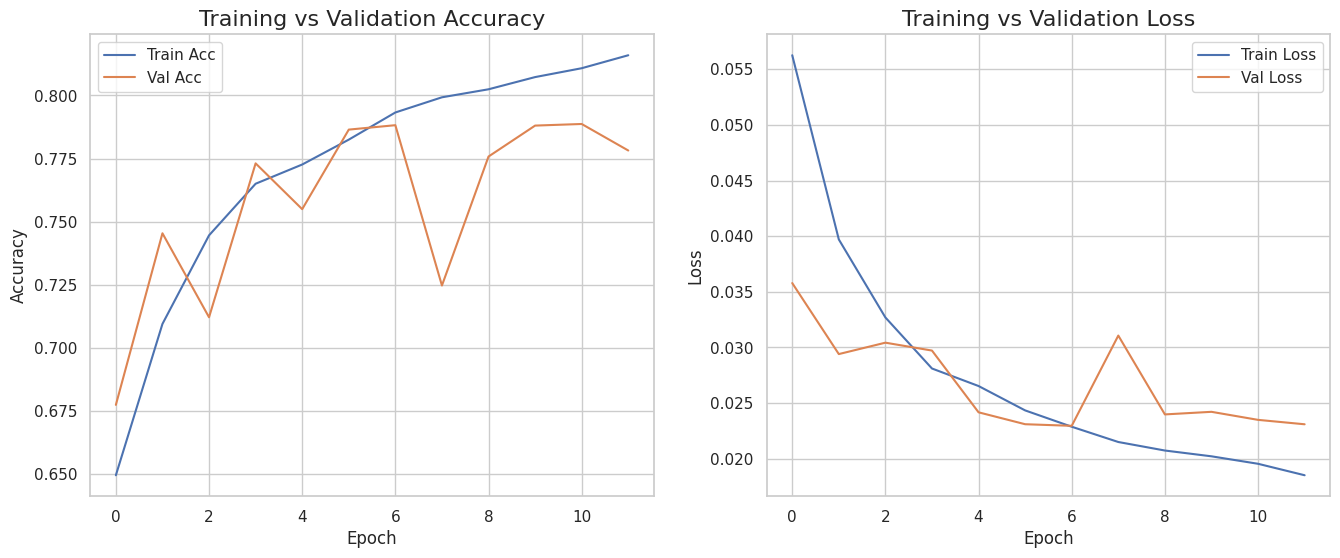

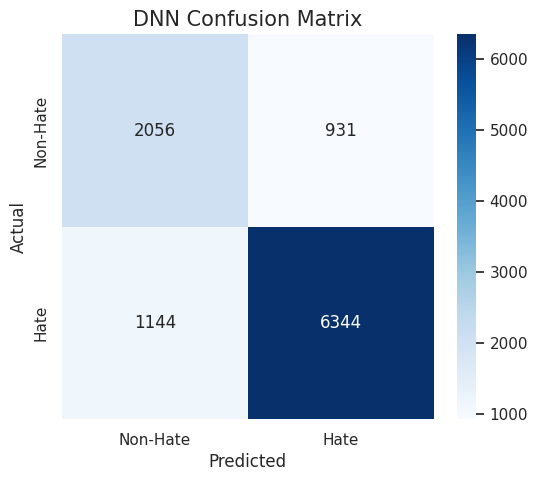

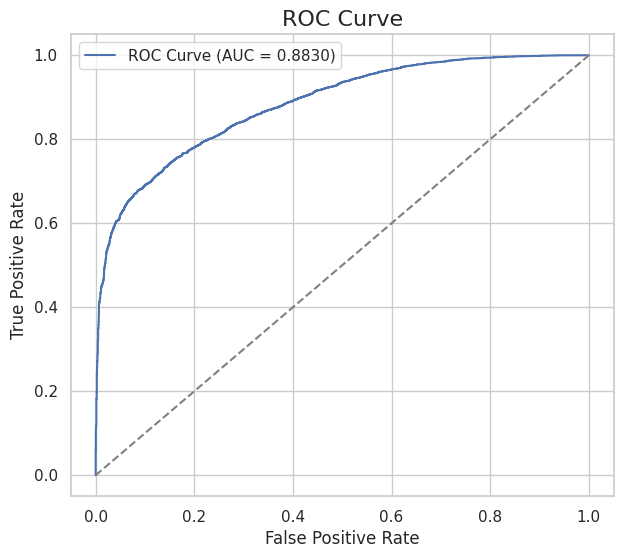

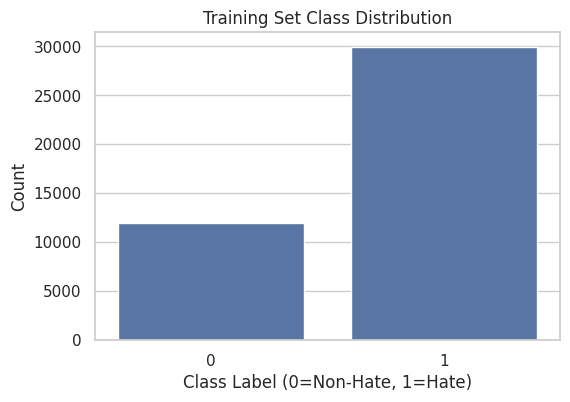


Top words indicating HATE:
bitch  (6.399)
pussy  (5.558)
bitches  (5.203)
kike  (4.587)
hoes  (4.042)
niggah  (3.760)
nigger  (3.710)
cunt  (3.447)
faggot  (3.397)
pussies  (3.341)
spic  (3.180)
retarded  (3.138)
hoe  (3.136)
fag  (3.077)
muzzies  (2.937)
faggots  (2.809)
retard  (2.761)
niggers  (2.707)
muslimes  (2.649)
nigguh  (2.649)

Top words indicating NON-HATE:
yankees  (-2.331)
charlie  (-2.320)
mocks  (-2.121)
sole  (-1.950)
apes  (-1.887)
muted  (-1.862)
yellow  (-1.832)
phoenix  (-1.790)
bird  (-1.731)
finding  (-1.724)
slur  (-1.715)
yankee  (-1.703)
sleepy  (-1.689)
makin  (-1.673)
crow  (-1.661)
lane  (-1.654)
mock  (-1.651)
indians  (-1.650)
hun  (-1.582)
user  (-1.582)


In [ ]:
# ================================================================
# 📊 VISUALIZATION SUITE FOR HYBRID MODEL (DNN + SVM)
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score,
    classification_report
)
import numpy as np

sns.set(style="whitegrid")

# ================================================================
# 1️⃣ ACCURACY & LOSS CURVES (DNN)
# ================================================================
def plot_training_history(history):
    plt.figure(figsize=(16,6))

    # ---------- Accuracy ----------
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Training vs Validation Accuracy", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend()

    # ---------- Loss ----------
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training vs Validation Loss", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()

    plt.show()


# Call after training
plot_training_history(history)


# ================================================================
# 2️⃣ CONFUSION MATRIX (DNN)
# ================================================================
def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title, fontsize=15)
    plt.show()

plot_conf_matrix(y_test, dnn_pred, "DNN Confusion Matrix")


# ================================================================
# 3️⃣ ROC CURVE (DNN)
# ================================================================
def plot_roc(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
    plt.plot([0,1], [0,1], linestyle='--', color='gray')

    plt.title("ROC Curve", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend()
    plt.show()

plot_roc(y_test, dnn_probs)


# ================================================================
# 4️⃣ CLASS DISTRIBUTION PLOT
# ================================================================
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Training Set Class Distribution")
plt.xlabel("Class Label (0=Non-Hate, 1=Hate)")
plt.ylabel("Count")
plt.show()


# ================================================================
# 5️⃣ OPTIONAL: SVM FEATURE IMPORTANCE (TF-IDF)
#       Shows top 20 words for HATE and NON-HATE
# ================================================================
def svm_feature_importance(svm_model, vectorizer, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    coefs = svm_model.coef_[0]

    top_pos = np.argsort(coefs)[-top_n:]
    top_neg = np.argsort(coefs)[:top_n]

    print("\nTop words indicating HATE:")
    for idx in reversed(top_pos):
        print(f"{feature_names[idx]}  ({coefs[idx]:.3f})")

    print("\nTop words indicating NON-HATE:")
    for idx in top_neg:
        print(f"{feature_names[idx]}  ({coefs[idx]:.3f})")

# run for SVM only:
svm_feature_importance(svm_clf, tfidf_vectorizer)


In [ ]:
!pip install emoji==0.6.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=7c78d19a53f720a5dbedbbb5f11ac598022eb17cf8d827b60b3dfea47cbd48f2
  Stored in directory: /root/.cache/pip/wheels/0d/bf/a2/536017b4a6232aef0fb92831af35facd6590c0af0f3983f63b
Successfully built emoji


In [ ]:
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

keras_path = "/content/drive/MyDrive/HybridFeatures/Hybrid_DNN_Focal_Best.keras"

try:
    model_raw = tf.keras.models.load_model(keras_path, compile=False)
    print("Loaded SavedModel .keras file successfully!")
except Exception as e:
    print("FAILED:", e)


FAILED: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 6536], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']


In [ ]:
import binascii

path = "/content/drive/MyDrive/HybridFeatures/Hybrid_DNN_Focal_Best.keras"

with open(path, "rb") as f:
    print(binascii.hexlify(f.read(200)))


b'504b0304140000000000000021003e783eef40000000400000000d0000006d657461646174612e6a736f6e7b226b657261735f76657273696f6e223a2022332e31302e30222c2022646174655f7361766564223a2022323032352d31312d32374031303a31383a3332227d504b0304140000000000000021009ea92b0779200000792000000b000000636f6e6669672e6a736f6e7b226d6f64756c65223a20226b65726173222c2022636c6173735f6e616d65223a202253657175656e7469616c222c2022636f6e'


In [ ]:
import zipfile
import os
import tempfile
import shutil

keras_zip = "/content/drive/MyDrive/HybridFeatures/Hybrid_DNN_Focal_Best.keras"
extract_dir = "/content/drive/MyDrive/HybridFeatures/extracted_focal_best/"

# Clean old extraction
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)

os.makedirs(extract_dir, exist_ok=True)

# Extract the .keras ZIP
with zipfile.ZipFile(keras_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted files:", os.listdir(extract_dir))


Extracted files: ['metadata.json', 'config.json', 'model.weights.h5']


In [ ]:


from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pickle
import re
import unicodedata
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
import os


print("Drive mounted + imports loaded.")



emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
    "\U00002700-\U000027BF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA70-\U0001FAFF"
    "]+", flags=re.UNICODE
)

def remove_emojis(text):
    return emoji_pattern.sub(" ", text)




class EnglishHinglishCleaner:
    def __init__(self):

        self.english_abuse = {
            r"f[\W_]*u[\W_]*c[\W_]*k": "fuck",
            r"b[\W_]*i[\W_]*t[\W_]*c[\W_]*h": "bitch",
            r"sh[\W_]*i[\W_]*t": "shit",
            r"ass[\W_]*h[\W_]*o[\W_]*l[\W_]*e": "asshole",
            r"mother[\W_]*fucker": "motherfucker",
            r"mf+": "motherfucker",
            r"cunt": "cunt",
            r"bsdk": "behenchod",
            r"bhosdi.?ke": "bhosdika",
            r"randi": "prostitute",
            r"lavde": "penis",
            r"gaandu+": "gandu"
        }

        self.slang = {
            r"\bu\b": "you",
            r"\bur\b": "your",
            r"\bomg\b": "oh my god",
            r"\bwtf\b": "what the fuck",
            r"\blmao\b": "laughing",
            r"\blol\b": "laugh"
        }

        self.contractions = {
            r"can't": "can not",
            r"won't": "will not",
            r"i'm": "i am",
            r"don't": "do not",
            r"it's": "it is",
            r"they're": "they are",
            r"you're": "you are"
        }

        self.roman_abuse = {
            r"madar.?chod": "madarchod",
            r"behn.?chod": "behenchod",
            r"chuti.?ya": "chutiya",
            r"gandu+": "gandu",
            r"harami": "harami",
            r"kutta": "kutta",
            r"sala": "sala",
            r"bsdk": "behenchod",
            r"bhosdi.?ke": "bhosdika",
            r"lavde": "lavda",
        }

    def clean(self, text):
        text = unicodedata.normalize("NFKC", text)
        text = remove_emojis(text)

        text = re.sub(r"http\S+|www\S+", " ", text)
        text = re.sub(r"[@#]\w+", " ", text)
        text = re.sub(r"[^\w\s]", " ", text)

        for p, r in self.contractions.items():
            text = re.sub(p, r, text, flags=re.IGNORECASE)
        for p, r in self.slang.items():
            text = re.sub(p, r, text, flags=re.IGNORECASE)
        for p, r in self.english_abuse.items():
            text = re.sub(p, r, text, flags=re.IGNORECASE)
        for p, r in self.roman_abuse.items():
            text = re.sub(p, r, text, flags=re.IGNORECASE)

        return re.sub(r"\s+", " ", text).strip()



class HindiCleaner:
    def __init__(self):
        self.hindi_abuse = {
            r"मादर.?चोद": "मादरचोद",
            r"भें.?चोद": "भेंचोद",
            r"बहन.?चोद": "बहनचोद",
            r"चुत.?िया": "चूतिया",
            r"गांडु+": "गांडू",
            r"हरामी": "हरामी",
            r"कुत्ता+": "कुत्ता",
            r"साला": "साला",
        }
        self.hindi_punct = "।॥"

    def clean(self, text):
        text = unicodedata.normalize("NFKC", text)
        text = remove_emojis(text)

        text = re.sub(r"[0-9०-९]+", " ", text)
        text = re.sub(r"http\S+|www\S+", " ", text)
        text = re.sub(rf"[{self.hindi_punct}]", " ", text)

        for p, r in self.hindi_abuse.items():
            text = re.sub(p, r, text, flags=re.IGNORECASE)

        text = re.sub(r"[^\w\s\u0900-\u097F]", " ", text)
        return re.sub(r"\s+", " ", text).strip()




hindi_script_regex = re.compile(r"[\u0900-\u097F]")

class UnifiedCleaner:
    def __init__(self):
        self.clean_en = EnglishHinglishCleaner()
        self.clean_hi = HindiCleaner()

    def clean(self, text):
        if not isinstance(text, str):
            return ""

        text = remove_emojis(text)
        out = []

        for w in text.split():
            if hindi_script_regex.search(w):
                out.append(self.clean_hi.clean(w))
            else:
                out.append(self.clean_en.clean(w))

        return re.sub(r"\s+", " ", " ".join(out)).strip()


cleaner = UnifiedCleaner()
print("Unified cleaner ready.")




feature_path = "/content/drive/MyDrive/HybridFeatures/"

with open(feature_path + "tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

tfidf_dim = len(tfidf_vectorizer.get_feature_names_out())
print("TF-IDF loaded.")




dim = 768

bertweet_tok = AutoTokenizer.from_pretrained("vinai/bertweet-base")
bertweet_model = TFAutoModel.from_pretrained("vinai/bertweet-base", from_pt=True)

mbert_tok = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
mbert_model = TFAutoModel.from_pretrained("bert-base-multilingual-cased", from_pt=True)

print("BERT models loaded.")




english_regex = re.compile(r"[A-Za-z]")
roman_words = {
    "kya","hai","tu","tum","bhai","pagal",
    "madarchod","behenchod","bc","mc","chutiya",
    "gunda","ullu","bsdk","bhosdike","lavde"
}

contains_hindi = lambda t: bool(hindi_script_regex.search(t))
contains_english = lambda t: bool(english_regex.search(t))
contains_roman = lambda t: any(w in roman_words for w in t.lower().split())

def split_mixed(t):
    eng, hin = [], []
    for w in t.split():
        if contains_hindi(w): hin.append(w)
        else: eng.append(w)
    return " ".join(eng) or "[BLANK]", " ".join(hin) or "[BLANK]"


def encode_bertweet(texts):
    enc = bertweet_tok(texts, padding=True, truncation=True,
                       max_length=128, return_tensors="tf")
    return bertweet_model(enc)["last_hidden_state"][:, 0, :].numpy()


def encode_mbert(texts):
    enc = mbert_tok(texts, padding=True, truncation=True,
                    max_length=128, return_tensors="tf")
    return mbert_model(enc)["last_hidden_state"][:, 0, :].numpy()





def extract_features_single(text):

    text = remove_emojis(text)

    original_hin = contains_hindi(text)
    original_eng = contains_english(text)

    cleaned = cleaner.clean(text)
    tfidf_vec = tfidf_vectorizer.transform([cleaned]).toarray()

    if original_hin and not original_eng:
        lang = "PURE_HINDI"
    else:
        ch = contains_hindi(cleaned)
        ce = contains_english(cleaned)
        cr = contains_roman(cleaned)

        if ch and ce:
            lang = "MIX"
        elif ch:
            lang = "PURE_HINDI"
        elif cr:
            lang = "ROMAN_HINDI"
        else:
            lang = "ENGLISH"

    bert_vec = np.zeros((1, dim * 2))

    if lang == "ENGLISH":
        bert_vec[:, :dim] = encode_bertweet([cleaned])

    elif lang in ["PURE_HINDI", "ROMAN_HINDI"]:
        bert_vec[:, :dim] = encode_mbert([cleaned])

    else:
        e, h = split_mixed(cleaned)
        be = encode_bertweet([e])
        bh = encode_mbert([h])
        bert_vec = np.concatenate([be, bh], axis=1)

    final = np.hstack([tfidf_vec, bert_vec])
    return final, cleaned, lang





weights_path = "/content/drive/MyDrive/HybridFeatures/extracted_focal_best/model.weights.h5"

def build_model(input_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

input_dim = tfidf_dim + 1536
model = build_model(input_dim)
_ = model(tf.zeros((1, input_dim)))
model.load_weights(weights_path)

print("Model loaded successfully!")





def predict_text(raw_text):
    vec, cleaned, lang = extract_features_single(raw_text)

    if lang == "PURE_HINDI":
        TH = 0.60
    elif lang == "ROMAN_HINDI":
        TH = 0.48
    else:
        TH = 0.50

    prob = model.predict(vec)[0][0]
    label = "HATE" if prob >= TH else "NON-HATE"

    print("\n==============================")
    print("RAW:", raw_text)
    print("CLEANED:", cleaned)
    print("LANG:", lang)
    print("PREDICTION:", label)
    print("PROBABILITY:", prob)
    print("==============================\n")

    return label, prob


Mounted at /content/drive
Drive mounted + imports loaded.
Unified cleaner ready.
TF-IDF loaded.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If yo

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT models loaded.
Model loaded successfully!


In [ ]:
predict_text("Bhag bc, warna phod dunga mf")
predict_text("मैंने अभी-अभी इस किताब को पढ़कर खत्म किया है, और यह अविश्वसनीय है! 🤩 लेखक ने जिस तरह से हर अध्याय को पेश किया है, वह बेहद शानदार है। कहानी इतनी गहन और विचारोत्तेजक है कि मैं पूरी रात सो नहीं पाया! मैं निश्चित रूप से इसे अपने दोस्तों को सुझाऊंगा। इसकी भाषा बहुत सरल और प्रभावी है। यह ज़रूर सबके पास होनी चाहिए। आपको इसे अवश्य पढ़ना चाहिए। धन्यवाद @author_official इस उत्कृष्ट कृति के लिए। 💯👍U can't be serious @random_user123!! They're not even human, honestly. Their whole culture is rotten to the core; they need to go back where they came from ASAP!!! 🤮🤮 I swear, idiots like that are why this country is failing. Get out! You’re just an anchor on society! 😠😡 Fools!!! Why does anyone defend this crap?! They've completely destroyed the neighborhood, and the media pretends NOTHING'S wrong. It's truly unbelievable. 😤 ")
predict_text("You’re kind but today you’re acting like a jerk assh*le ")
predict_text("ये लोग कभी नहीं सुधरेंगे। इनकी पूरी मानसिकता ही दूषित है, और ये हमारे समाज को जहर दे रहे हैं!!! ये बस देश का नाम खराब कर रहे हैं और इनका अस्तित्व ही एक बड़ा धब्बा है। इन्हें तुरंत यहाँ से निकाल देना चाहिए। सरकार को इनके खिलाफ सख्त कार्रवाई करनी चाहिए!! बेशर्म और नीच कहीं के!! ये सब सिर्फ वोट बैंक के लिए यहाँ रह रहे हैं। ये पूरी तरह से असफल और अयोग्य हैं।")


1/1 [==============================] - 0s 28ms/step

RAW: Bhag bc, warna phod dunga mf
CLEANED: Bhag bc warna phod dunga motherfucker
LANG: ROMAN_HINDI
PREDICTION: HATE
PROBABILITY: 0.56345063

1/1 [==============================] - 0s 22ms/step

RAW: मैंने अभी-अभी इस किताब को पढ़कर खत्म किया है, और यह अविश्वसनीय है! 🤩 लेखक ने जिस तरह से हर अध्याय को पेश किया है, वह बेहद शानदार है। कहानी इतनी गहन और विचारोत्तेजक है कि मैं पूरी रात सो नहीं पाया! मैं निश्चित रूप से इसे अपने दोस्तों को सुझाऊंगा। इसकी भाषा बहुत सरल और प्रभावी है। यह ज़रूर सबके पास होनी चाहिए। आपको इसे अवश्य पढ़ना चाहिए। धन्यवाद @author_official इस उत्कृष्ट कृति के लिए। 💯👍U can't be serious @random_user123!! They're not even human, honestly. Their whole culture is rotten to the core; they need to go back where they came from ASAP!!! 🤮🤮 I swear, idiots like that are why this country is failing. Get out! You’re just an anchor on society! 😠😡 Fools!!! Why does anyone defend this crap?! They've completely destroyed the neighborh

('HATE', np.float32(0.676554))

In [ ]:
!pip install flask pyngrok



In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("33ZHPX593kVw2ZbAHEgqelWEBr4_5RWvxk77xEvScPyUXuH46")


In [ ]:
from flask import Flask, request, render_template_string
from pyngrok import ngrok

html_page = """
<!DOCTYPE html>
<html>
<head>
    <title>Hate Speech Detector</title>
    <style>
        body {
            font-family: 'Segoe UI', sans-serif;
            background: linear-gradient(135deg, #0A0A0A, #111111);
            color: white;
            text-align: center;
            padding: 40px;
        }

        h1 {
            font-size: 45px;
            color: #00ff88;
            text-shadow: 0 0 15px #00ff88;
            margin-bottom: 35px;
        }

        /* ⭐ Big comment-style INPUT box */
        textarea {
            width: 75%;
            height: 160px;
            padding: 18px;
            border-radius: 18px;
            border: 2px solid #00ff88;
            outline: none;
            resize: none;
            font-size: 20px;
            background: #1b1b1b;
            color: white;
            box-shadow: 0 0 15px rgba(0, 255, 136, 0.35);
            transition: 0.3s;
        }

        textarea:focus {
            border-color: #00ffcc;
            box-shadow: 0 0 20px #00ffcc;
        }

        button {
            margin-top: 25px;
            padding: 15px 40px;
            background: #00C853;
            border: none;
            font-size: 22px;
            border-radius: 14px;
            cursor: pointer;
            color: white;
            transition: 0.3s;
        }
        button:hover {
            background: #00E676;
            box-shadow: 0 0 15px #00E676;
        }

        /* ⭐ Big comment-style PREDICTION box */
        .comment-box {
            margin-top: 40px;
            width: 75%;
            margin-left: auto;
            margin-right: auto;
            padding: 28px;
            background: #181818;
            border-left: 7px solid #00E676;
            border-radius: 14px;
            font-size: 32px;
            font-weight: bold;
            color: white;
            text-align: left;
            box-shadow: 0 0 18px rgba(0, 230, 118, 0.35);
        }

        /* Popup message */
        .popup {
            visibility: hidden;
            min-width: 300px;
            color: white;
            text-align: center;
            border-radius: 12px;
            padding: 16px;
            position: fixed;
            z-index: 100;
            left: 50%;
            bottom: 45px;
            transform: translateX(-50%);
            font-size: 22px;
        }
        .popup.show {
            visibility: visible;
            animation: fadein 0.5s, fadeout 0.5s 2.5s;
        }

        @keyframes fadein {
            from { bottom: 20px; opacity: 0; }
            to { bottom: 45px; opacity: 1; }
        }
        @keyframes fadeout {
            from { bottom: 45px; opacity: 1; }
            to { bottom: 20px; opacity: 0; }
        }
    </style>
</head>

<body>

    <h1>🔥 Hate Speech Detection System 🔥</h1>

    <form method="POST">
        <textarea name="user_text" placeholder="Write your message here..." required>{{ user_text }}</textarea>
        <br>
        <button type="submit">Detect</button>
    </form>

    {% if prediction %}
    <div class="comment-box">
        {{ prediction }}
    </div>

    <div id="popup" class="popup"
         style="background-color: {{ 'red' if is_hate else '#00C853' }};">
        {{ prediction }}
    </div>

    <script>
        document.getElementById("popup").classList.add("show");
    </script>
    {% endif %}

</body>
</html>
"""


app = Flask(__name__)

@app.route("/", methods=["GET", "POST"])
def home():
    prediction = None
    is_hate = False
    user_text = ""

    if request.method == "POST":
        user_text = request.form["user_text"]


        vec, cleaned, lang = extract_features_single(user_text)
        prob = model.predict(vec)[0][0]

        # thresholds
        if lang == "PURE_HINDI":
            TH = 0.60
        elif lang == "ROMAN_HINDI":
            TH = 0.48
        else:
            TH = 0.50

        if prob >= TH:
            prediction = "HATE ❌"
            is_hate = True
        else:
            prediction = "NON-HATE ✅"
            is_hate = False

    return render_template_string(
        html_page,
        prediction=prediction,
        is_hate=is_hate,
        user_text=user_text
    )

public_url = ngrok.connect(5000)
print("🌍 Public Web URL:", public_url)

app.run(port=5000)

🌍 Public Web URL: NgrokTunnel: "https://braver-unpublicly-sandy.ngrok-free.dev" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:05:57] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:05:58] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 38ms/step


INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:06:03] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 17ms/step


INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:06:47] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 153ms/step


INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:07:17] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 17ms/step


INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:08:00] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 28ms/step


INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:08:55] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:09:46] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 16ms/step


INFO:werkzeug:127.0.0.1 - - [22/Dec/2025 12:10:02] "POST / HTTP/1.1" 200 -
